## 03_Classification Modeling & Sentiment Analysis

This Notebook reads in data scraped from three subreddits that was preprocessed and concatenated to form datasets for classification modeling.  Three classfication models are tested on subreddit Submissions, and two models tested on subreddit comments.  The notebook also contains plots of Sentiment Analysis for each of the subreddit groups, and finally a summary of findings with conclusions.

### Contents
- [Import Packages](#Import-Packages)
- [Read in Data](#Read-in-Data)
- [Baseline Proportions](#Get-Baseline-Class-Proportions)
- [Modeling](#Modeling)
    - [Model 1: Logistic Regression](#Model-1:-Logistic-Regression)
    - [Model 1b: Tfidf Vectorizer - Logistic Regression](#Model-1b:-Tfidf-Vectorizer---Logistic-Regression)
    - [Model 1c: CV Logistic Regression - Expand Parameters](#Model-1c:-CV-Logistic-Regression---Expand-Parameters)
    - [Model 1d: Logistic Regression on Comments ](#Model-1d:-Logistic-Regression-on-Comments)
    - [Support Vector Machine](#Support-Vector-Machine)
    - [Support Vector Machine on Comments](#Support-Vector-Machine-on-Comments)
    - [Random Forest](#Random-Forest)
- [Sentiment Analysis Plots](#Sentiment-Analysis-Plots)
- [Summary-and-Conclusions](#Summary-and-Conclusions)

## Import Packages

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re


from nltk.tokenize import RegexpTokenizer
from nltk import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from afinn import Afinn

from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline

### Read in Data

In [6]:
sdc_fut_sub = pd.read_csv('./datasets/selfdrive_fut_sub.csv', index_col=[0], na_filter = False)
sdc_fut_com = pd.read_csv('./datasets/selfdrive_fut_com.csv', index_col=[0], na_filter = False)
sdc_tech_sub = pd.read_csv('./datasets/selfdrive_tech_sub.csv', index_col=[0], na_filter = False)
sdc_tech_com = pd.read_csv('./datasets/selfdrive_tech_sub.csv', index_col=[0], na_filter = False)

srch_sub = pd.read_csv('./datasets/search_sub.csv', index_col=[0], na_filter = False)
srch_com = pd.read_csv('./datasets/search_com.csv', index_col=[0], na_filter = False)
 

In [12]:
sdc_fut_sub.head()

,author,id,title,subreddit,target,tokens,lemma,stems,sent_score
0,aibits,did2fk,"Keen to develop self-driving cars, Hyundai Mot...",selfdrivingcars,1,"['Keen', 'to', 'develop', 'self', 'driving', '...",Keen to develop self driving car Hyundai Motor...,keen to develop self drive car hyundai motor g...,1.0
1,tamu,dia5o0,Texas A&amp;M Lands $ Million Federal Grant To...,selfdrivingcars,1,"['Texas', 'A', 'amp', 'M', 'Lands', 'Million',...",Texas A amp M Lands Million Federal Grant To S...,texa A amp M land million feder grant To studi...,1.0
2,aibits,di9aub,Welcome to the DriveML Huawei Autonomous Vehi...,selfdrivingcars,1,"['Welcome', 'to', 'the', 'DriveML', 'Huawei', ...",Welcome to the DriveML Huawei Autonomous Vehic...,welcom to the driveml huawei autonom vehicl ch...,1.0
3,Avenue21,di8zvp,There is a puzzle picturing a driverless Paris...,selfdrivingcars,1,"['There', 'is', 'a', 'puzzle', 'picturing', 'a...",There is a puzzle picturing a driverless Paris...,there is a puzzl pictur a driverless pari now,0.0
4,aibits,di3hc7,Top self-driving trucks in the world,selfdrivingcars,1,"['Top', 'self', 'driving', 'trucks', 'in', 'th...",Top self driving truck in the world,top self drive truck in the world,2.0


### Get Baseline Class Proportions

In [13]:
# Check value count proportions for y

In [14]:
sdc_fut_sub['target'].value_counts(normalize=True)

1    0.507266
0    0.492734
Name: target, dtype: float64

In [15]:
sdc_fut_com['target'].value_counts(normalize=True)

1    0.519389
0    0.480611
Name: target, dtype: float64

In [16]:
sdc_tech_sub['target'].value_counts(normalize=True)

1    0.510234
0    0.489766
Name: target, dtype: float64

In [17]:
sdc_tech_com['target'].value_counts(normalize=True)

1    0.510234
0    0.489766
Name: target, dtype: float64

All classes are well balanced because we pulled the same number from both subreddits.  The small discrepancies are due removal of duplicates.

## Modeling

### Train Test Split

In [18]:
# Define X and y, Split Training and Testing Data

X = sdc_fut_sub['lemma']
y = sdc_fut_sub['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 88)

In [ ]:
X2.head()

In [19]:
X2 = sdc_fut_com['lemma']
y2 = sdc_fut_com['target']

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, random_state = 88)

### Setup Model Pipeline and Parameters

In [75]:
# Standard Scaler Pipes with Countvectorizer and Logistic Regression

pipe_cv_sc = Pipeline([
    ('cv', CountVectorizer()),
    ('sc', StandardScaler()),
    ('logreg', LogisticRegression())])


pipe_tf_sc = Pipeline([
    ('tf', TfidfVectorizer()),
    ('sc', StandardScaler()),
    ('logreg', LogisticRegression())])


In [76]:
#  Parameter grid for Countvectorizer, Tfidf Vectorizer, and Logistic Regression

cv_params_sc = {'cv__stop_words': ['english', None], 
            'cv__ngram_range': [(1, 1), (1, 2), (1,3)], 
            'cv__max_features': [1000, 2000, 3000],
            'sc__with_mean': [False],
            'logreg__penalty': ['l1', 'l2'], 
            'logreg__C': [0.01, 0.1, 1, 10],
            'logreg__max_iter': [1000]}

tf_params_sc = {'tf__stop_words': ['english', None], 
            'tf__ngram_range': [(1, 1), (1, 2), (1, 3)],
            'tf__max_features': [1000, 2000, 3000],
            'sc__with_mean': [False],
            'logreg__penalty': ['l1', 'l2'], 
            'logreg__C': [0.01, 0.1, 1, 10]}

### Model 1: Logistic Regression

In [77]:
# Instantiate GridSearch object using above pipeline and parameter grid

lr_cv_sc_grid = GridSearchCV(pipe_cv_sc, cv_params_sc, cv=3, verbose=1)

lr_tf_sc_grid = GridSearchCV(pipe_tf_sc, tf_params_sc, cv=3, verbose=1)

In [33]:
# Fit the grid search object to the training data

lr_cv_sc_grid.fit(X_train, y_train)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 432 out of 432 | elapsed:  2.0min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('cv',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                              

In [35]:
# Print Scores

print(f'X Grid Best Score: {lr_cv_sc_grid.best_score_}')
print(f'X Train Score: {lr_cv_sc_grid.score(X_train, y_train)}')
print(f'X Test score: {lr_cv_sc_grid.score(X_test, y_test)}')

X Grid Best Score: 0.9004243281471004
X Train Score: 0.958981612446959
X Test score: 0.8918116249469665


Logistic Regression with Count Vectorizer performed fairley well with 89% accuracy but was rather overfit with a training score of 6 percentage points higher than test score.

In [36]:
# Get best Parameters

lr_cv_sc_grid.best_params_

{'cv__max_features': 2000,
 'cv__ngram_range': (1, 1),
 'cv__stop_words': None,
 'logreg__C': 0.1,
 'logreg__penalty': 'l1',
 'sc__with_mean': False}

In [37]:
# Get coefficients

log_reg_coef = lr_cv_sc_grid.best_estimator_.named_steps['logreg'].coef_

In [38]:
len(log_reg_coef[0])

2000

In [39]:
# Get Feature names

feats = lr_cv_sc_grid.best_estimator_.named_steps['cv'].get_feature_names()

In [41]:
# Put Features Names and Coefficients in Dataframe

feats_df = pd.DataFrame(log_reg_coef[0], feats)
feats_df = feats_df.reset_index()
feats_df.columns = ['features', 'coefs']

In [183]:
# Sort Features by low 10 and top 10

low_feats = feats_df.sort_values('coefs').head(10)
high_feats = feats_df.sort_values('coefs', ascending=False).head(10)

In [187]:
high_feats

,features,coefs
1930,waymo,0.974556
528,driving,0.789985
272,car,0.671106
144,autonomous,0.665519
146,autopilot,0.578761
1750,tesla,0.556826
1015,lidar,0.469925
526,driverless,0.430110
413,cruise,0.392330
1557,sdc,0.391822


In [188]:
low_feats

,features,coefs
1638,solar,-0.314605
576,energy,-0.308775
329,climate,-0.287304
880,income,-0.273740
1410,quite,-0.267260
1650,space,-0.243045
44,ai,-0.231158
1206,of,-0.223896
1789,to,-0.221488
690,flight,-0.220618


In [43]:
# Create predictions data frame

preds_df = pd.DataFrame(index=X_test.index)
preds_df['log_cv_pred'] = lr_cv_sc_grid.predict(X_test)

In [46]:
preds_df.head()

,log_cv_pred
886,0
558,1
255,0
979,0
17,0


In [100]:
#pred = cv_grid.predict(X_test)
#test['Survived'] = pred

In [47]:
# Add X_test to Predictions dataframe

preds_df['X_test'] = X_test

# Rename X_test to original name; lemma

preds_df.rename(columns = {'X_test': 'lemma'}, inplace=True)

In [48]:
preds_df.head()

,log_cv_pred,lemma
886,0,Top Automotive Companies to Watch at CEBIT
558,1,Autonomous vehicle tech firm Aurora gear up fo...
255,0,How Photos of Your Kids Are Powering Surveilla...
979,0,China increasingly challenge American dominanc...
17,0,The future of factory made bread can be tasty


In [49]:
# Create new dataframe with merge of predictions and original Selfdrivingcars + futurology Submissions

sdc_fut_sub_pred = pd.merge(preds_df, sdc_fut_sub, on='lemma')

In [50]:
# Define Misclassifed Submissions

misclassed = sdc_fut_sub_pred.loc[sdc_fut_sub_pred['log_cv_pred'] != sdc_fut_sub_pred['target'], :]

In [51]:
# Get count of false positives

fp = misclassed[misclassed['log_cv_pred'] == 1]
len(fp)

114

In [52]:
# Get count of false negatives

fn = misclassed[misclassed['log_cv_pred'] == 0]
len(fn)

142

In [53]:
# Get total count of misclassified posts

misclassed.shape[0]

256

In [54]:
# Get count of total rows intest data

sdc_fut_sub_pred.shape[0]

2372

In [56]:
# Define y_true and y_predicte

y_true = sdc_fut_sub_pred['target']
y_pred = sdc_fut_sub_pred['log_cv_pred']

In [57]:
# Create Confusion Matrix

cm = confusion_matrix(y_true, y_pred)
cm

array([[1088,  114],
       [ 142, 1028]])

### Model 1b: Tfidf Vectorizer - Logistic Regression

In [58]:
# Fit the Tfidf grid object to Training data

lr_tf_sc_grid.fit(X_train, y_train)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 432 out of 432 | elapsed:  2.2min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('tf',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                            

In [59]:
print(f'LogReg tf Grid Best Score: {lr_tf_sc_grid.best_score_}')
print(f'LogReg tf Train Score: {lr_tf_sc_grid.score(X_train, y_train)}')
print(f'Logreg tf Test score: {lr_tf_sc_grid.score(X_test, y_test)}')

LogReg tf Grid Best Score: 0.9016973125884017
LogReg tf Train Score: 0.9768033946251768
Logreg tf Test score: 0.8926601612218923


Logist Regression with Tfidf Vectorizer performed roughly the same as Count Vectorizer, except that it was even more overfit than Cvec, with the training score of 8 percentage points higher than the test score.  With this knowlege, we will select the CountVectorizer model as the better, more generalizeable model.

In [61]:
lr_tf_sc_grid.best_params_

{'logreg__C': 0.1,
 'logreg__penalty': 'l1',
 'sc__with_mean': False,
 'tf__max_features': 3000,
 'tf__ngram_range': (1, 3),
 'tf__stop_words': 'english'}

### Model 1c: CV Logistic Regression - Expand Parameters

In [66]:
# New Parameter grid with additional max features

pipe2_cv_sc = Pipeline([
    ('cv', CountVectorizer()),
    ('sc', StandardScaler()),
    ('logreg', LogisticRegression())])


lr_cv_params_2 = {'cv__stop_words': ['english', None], 
            'cv__ngram_range': [(1, 1), (1, 2), (1,3)], 
            'cv__max_features': [5000, 10000, 15000, 20000],
            'sc__with_mean': [False],
            'logreg__penalty': ['l1', 'l2'], 
            'logreg__C': [0.01, 0.1, 1, 10]}

lr_tf_params_2 = {'tf__stop_words': ['english', None], 
            'tf__ngram_range': [(1, 1), (1, 2)],
            'tf__max_features': [1000, 2000, 3000],
            'logreg__penalty': ['l1', 'l2'], 
            'logreg__C': [0.01, 0.1, 1, 10]}

In [67]:
# Instantiate New GridSearch object using new parameters

lr_cv_sc_grid_2 = GridSearchCV(pipe2_cv_sc, lr_cv_params_2, cv=3, verbose=1)

#lr_tf_sc_grid = GridSearchCV(pipe_tf_sc, tf_params_sc, cv=3, verbose=1)

In [68]:
lr_cv_sc_grid_2.fit(X_train, y_train)

Fitting 3 folds for each of 192 candidates, totalling 576 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 576 out of 576 | elapsed:  2.9min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('cv',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                              

In [70]:
print(f'LogReg cv Grid 2 Best Score: {lr_cv_sc_grid_2.best_score_}')
print(f'LogReg cv Train 2 Score: {lr_cv_sc_grid_2.score(X_train, y_train)}')
print(f'Logreg cv Test 2 score: {lr_cv_sc_grid_2.score(X_test, y_test)}')

LogReg cv Grid 2 Best Score: 0.9025459688826025
LogReg cv Train 2 Score: 0.9821782178217822
Logreg cv Test 2 score: 0.9028425965210013


In [72]:
lr_cv_sc_grid_2.best_params_

{'cv__max_features': 5000,
 'cv__ngram_range': (1, 2),
 'cv__stop_words': None,
 'logreg__C': 0.1,
 'logreg__penalty': 'l1',
 'sc__with_mean': False}

The Logistic Regression Model accuracy improved only slightly, by 1 percentage point, by increasing the max features. Max features were tested up to 20,000, and yet the best parameter selected was 5000 features, just over double the number of features of the initial model.  This indicates that increasing the number of features up to 20,000 did not provide a more accurate model, and doubling the features from 2000 to 5000 only provided a 1 percentage point increase.

### Model 1d: Logistic Regression on Comments 

In [3]:
# Test Initial Logistic Regression model on Comments from r/selfdrivingcars and r/futurology

#lr_cv_sc_grid.fit(X2_train, y2_train)

Model solver could not converge when analyzing the comments in Selfdrivingcars and Futurology. Change the solver parameter to test again.

In [80]:
pipe_cv_sc = Pipeline([
    ('cv', CountVectorizer()),
    ('sc', StandardScaler()),
    ('logreg', LogisticRegression())])


pipe_tf_sc = Pipeline([
    ('tf', TfidfVectorizer()),
    ('sc', StandardScaler()),
    ('logreg', LogisticRegression())])


In [121]:
cv_params = {'cv__stop_words': ['english', None], 
            'cv__ngram_range': [(1, 1), (1, 2), (1,3)], 
            'cv__max_features': [1000, 2000, 3000],
            'logreg__penalty': ['l1','l2'], 
            'logreg__C': [0.01, 0.1, 1, 10],  
            }

tf_params_sc = {'tf__stop_words': ['english', None], 
            'tf__ngram_range': [(1, 1), (1, 2), (1, 3)],
            'tf__max_features': [1000, 2000, 3000],
            'sc__with_mean': [False],
            'logreg__penalty': ['l1', 'l2'], 
            'logreg__C': [0.01, 0.1, 1, 10],
            'logreg__max_iter': [1000],}

In [122]:
pipe_cv = Pipeline([
    ('cv', CountVectorizer()),
    ('logreg', LogisticRegression())])


pipe_tf = Pipeline([
    ('tf', TfidfVectorizer()),
    ('logreg', LogisticRegression())])


In [ ]:
# Logreg solvers: ‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’

Logistic Regression Model Solver still could not converge when testing all available solvers on Comments text data

In [ ]:
# Test Logistic Regression on Comments without Scaling 

In [123]:
lr_cv_grid = GridSearchCV(pipe_cv, cv_params, cv=3, verbose=1)

In [124]:
# Fit Model 1 Logistic Regression on Comments data without Scaling

lr_cv_grid.fit(X2_train, y2_train)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 432 out of 432 | elapsed:  6.1min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('cv',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                              

In [125]:
print(f'LogReg Non-Scale cv Grid Best Score: {lr_cv_grid.best_score_}')
print(f'LogReg Non-Scale cv Train Score: {lr_cv_grid.score(X2_train, y2_train)}')
print(f'Logreg Non-Scale cv Test score: {lr_cv_grid.score(X2_test, y2_test)}')

LogReg Non-Scale cv Grid Best Score: 0.8253477588871716
LogReg Non-Scale cv Train Score: 0.9341014472390052
Logreg Non-Scale cv Test score: 0.8297513695743785


Finally Logistic Regression solver was able to converge on the Comments data without scaling.  We saw earlier it was not able to converge after scaling the data.  

We see that the test score acuracy is 83%, about six percentage points below the Logistic Regression model for Selfdrivingcars Submissions and the model is overfit with a similar marging to the models on Submission data.

In [126]:
lr_cv_grid.best_params_

{'cv__max_features': 3000,
 'cv__ngram_range': (1, 1),
 'cv__stop_words': 'english',
 'logreg__C': 1,
 'logreg__penalty': 'l2'}

We also see that the Logistic Regression model (without scaling) for Comments has different best parameters than the initial model for Submissions. 

### Support Vector Machine

In [154]:
# Instantiate New Pipelines for Support Vector Machine

pipe_cv_svc = Pipeline([
    ('cv', CountVectorizer()),
    ('svc', SVC())])

pipe_tf_svc = Pipeline([
    ('tf', TfidfVectorizer()),
    ('svc', SVC())])

In [128]:
# SVC Kernels: ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid

In [155]:
# Initial Params used

svc_cv_params = {'cv__stop_words': ['english', None], 
            'cv__ngram_range': [(1, 1), (1, 2), (1,3)], 
            'cv__max_features': [1000, 2000, 3000],
            'svc__C': [0.01, 0.1, 1, 10], 
            'svc__kernel': ['rbf'],
            'svc__gamma': ['scale']}

svc_tf_params = {'tf__stop_words': ['english', None], 
            'tf__ngram_range': [(1, 1), (1, 2), (1, 3)],
            'tf__max_features': [1000, 2000, 3000],
            'svc__C': [0.01, 0.1, 1, 10], 
            'svc__kernel': ['rbf'],
            'svc__gamma': ['scale']}

In [156]:
# Expanding svc kernel and gamma parameters 

svc_cv_params_2 = {'cv__stop_words': ['english', None], 
            'cv__ngram_range': [(1, 1), (1, 2), (1,3)], 
            'cv__max_features': [1000, 2000, 3000],
            'svc__C': [0.01, 0.1, 1, 10], 
            'svc__kernel': ['linear', 'poly', 'sigmoid'],
            'svc__gamma': ['scale', 'auto']}

svc_tf_params_2 = {'tf__stop_words': ['english', None], 
            'tf__ngram_range': [(1, 1), (1, 2), (1, 3)],
            'tf__max_features': [1000, 2000, 3000],
            'svc__C': [0.01, 0.1, 1, 10], 
            'svc__kernel': ['linear', 'poly', 'sigmoid'],
            'svc__gamma': ['scale', 'auto']}

In [157]:
# Instantiate SVC GridSearch object

svc_cv_grid = GridSearchCV(pipe_cv_svc, svc_cv_params, cv=3, verbose=1)

svc_tf_grid = GridSearchCV(pipe_tf_svc, svc_tf_params, cv=3, verbose=1)

In [122]:
# Fit SVC Grid on Submissions Training Data

svc_cv_grid.fit(X_train, y_train)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 216 out of 216 | elapsed:  7.2min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('cv',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                              

In [123]:
svc_cv_grid.best_params_

{'cv__max_features': 3000,
 'cv__ngram_range': (1, 2),
 'cv__stop_words': 'english',
 'svc__C': 10,
 'svc__gamma': 'scale',
 'svc__kernel': 'rbf'}

Pros and Cons of SVMs
Pros
Exceptional perfomance (historically widely used)
Robust to outliers
Effective in high-dimensional data
Can work with non-linear boundaries
Fast to compute with most datasets (kernel trick)
Low risk of overfitting
Cons
Black box method
Can be slow on large datasets

In [125]:
print(f'SVC Grid Best Score: {svc_cv_grid.best_score_}')
print(f'SVC Train Score: {svc_cv_grid.score(X_train, y_train)}')
print(f'SVC Test score: {svc_cv_grid.score(X_test, y_test)}')

SVC Grid Best Score: 0.9045261669024045
SVC Train Score: 0.9923620933521924
SVC Test score: 0.8985999151463725


Using initial simple set of parameters, Support Vector Machine performed roughly identical to Logistic Regression on the Submissions text data. It was even more overfit, however, as its training score was as high as 99%.

In [159]:
# Run SVC Grid again with Expanded Parameter set on Submissions

svc_cv_grid_2 = GridSearchCV(pipe_cv_svc, svc_cv_params_2, cv=3, verbose=1)

svc_tf_grid_2 = GridSearchCV(pipe_tf_svc, svc_tf_params_2, cv=3, verbose=1)

In [160]:
svc_cv_grid_2.fit(X_train, y_train)

Fitting 3 folds for each of 432 candidates, totalling 1296 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1296 out of 1296 | elapsed: 39.9min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('cv',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                              

In [161]:
print(f'SVC Grid Best Score: {svc_cv_grid_2.best_score_}')
print(f'SVC Train Score: {svc_cv_grid_2.score(X_train, y_train)}')
print(f'SVC Test score: {svc_cv_grid_2.score(X_test, y_test)}')

SVC Grid Best Score: 0.9026874115983027
SVC Train Score: 0.9357850070721357
SVC Test score: 0.9049639372083157


In [162]:
svc_cv_grid_2.best_params_

{'cv__max_features': 3000,
 'cv__ngram_range': (1, 1),
 'cv__stop_words': None,
 'svc__C': 0.1,
 'svc__gamma': 'scale',
 'svc__kernel': 'linear'}

SVC performed roughly the same in final test accuracy with the expanded parameter set, but was much less overfit.  The training score dropped to within three percentage points of the Test score.  This model should be more generalizable to other unseen data from the two classes that we might be interested in classifying later.

### Support Vector Machine on Comments

In [163]:
# Fit initial SVC grid to Comments training data

svc_cv_grid.fit(X2_train, y2_train)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 216 out of 216 | elapsed: 18.0min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('cv',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                              

In [164]:
print(f'SVC Comments Grid Best Score: {svc_cv_grid.best_score_}')
print(f'SVC Comments Train Score: {svc_cv_grid.score(X_train, y_train)}')
print(f'SVC Comments Test score: {svc_cv_grid.score(X_test, y_test)}')

SVC Comments Grid Best Score: 0.8021638330757341
SVC Comments Train Score: 0.8152758132956153
SVC Comments Test score: 0.8239287229529062


Support Vector Machine performed roughlythe same as Logistic Regression in final test accuracy score, but the model was surprisingly well fit, even slightly underfit, to the test data.  This model would likely provide a more generalizeable model for any additional classification of future comments data.

## Random Forest

In [42]:
# Repost X and Y Assignments for ease of viewing. 
# Train random forest on same Submission data 
# from same two subreddits as above models.

X = sdc_fut_sub['lemma']
y = sdc_fut_sub['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 88)

In [52]:
# Define Random Forest pipelin and parameter grid

rf_pipe_cv = Pipeline([
    ('cv', CountVectorizer()),
    ('rf', RandomForestClassifier())])

rf_cv_params = {'cv__stop_words': ['english', None], 
            'cv__ngram_range': [(1, 1), (1, 2), (1,3)], 
            'cv__max_features': [1000, 2000, 3000],
            'rf__n_estimators': [100, 200],
            'rf__max_depth': [None, 1, 2, 3],}

In [53]:
# Instantiate RF grid search object

gs_rf = GridSearchCV(rf_pipe_cv, rf_cv_params, cv=3, verbose=1)

In [54]:
# Fit RG grid to Submission training data

gs_rf.fit(X_train, y_train)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 432 out of 432 | elapsed:  6.6min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('cv',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                              

In [55]:
print(f'RF Grid Best Score: {gs_rf.best_score_}')
print(f'RF Train Score: {gs_rf.score(X_train, y_train)}')
print(f'RF Test score: {gs_rf.score(X_test, y_test)}')

RF Grid Best Score: 0.9042432814710042
RF Train Score: 0.9961810466760962
RF Test score: 0.8960543063215952


In [58]:
gs_rf.best_params_

{'cv__max_features': 3000,
 'cv__ngram_range': (1, 1),
 'cv__stop_words': 'english',
 'rf__max_depth': None,
 'rf__n_estimators': 200}

Random Forest performed roughly the same as Logistic Regression and Support Vector machine on Submission test data with an accuracy score of 90%.  The model was significantly overfit however, similar to the LogReg model and initial SVC Model.

Comparing the three models, they all performed roughly the same on Submission Data at 90%. However, we saw that Support Vector Machine with 'linear' kernel provided the least overfit of the three models.  We only tested Logistic Regression and Support Vector Machine on Comments data, both of which scored around 83%, but again the Support Vector Machine model was the only model that best fit the entire data, including the test data.  Logistic Regression was overfit.

## Sentiment Analysis Plots

In [7]:
# Filter dataframes for individual Sentiment Analysis plots

sdc_sub = srch_sub[srch_sub['subreddit'] == 'selfdrivingcars']
fut_sub = srch_sub[srch_sub['subreddit'] == 'futurology']
tech_sub= srch_sub[srch_sub['subreddit'] == 'technology']

sdc_com = srch_com[srch_com['subreddit'] == 'selfdrivingcars']
fut_com = srch_com[srch_com['subreddit'] == 'futurology']
tech_com= srch_com[srch_com['subreddit'] == 'technology']

In [61]:
sdc_sub.head()

,author,id,title,subreddit,year,tokens,lemma,stems,sent_score
1,Sidewinder77,vn2lo,Sebastian Thrun on Google's Self-Driving Car,selfdrivingcars,2011,"['Sebastian', 'Thrun', 'on', 'Google', 's', 'S...",Sebastian Thrun on Google s Self Driving Car,sebastian thrun on googl s self drive car,0.0
2,Sidewinder77,vn2tg,5 Ways Self-Driving Cars Will Make You Love Co...,selfdrivingcars,2011,"['5', 'Ways', 'Self', 'Driving', 'Cars', 'Will...",5 Ways Self Driving Cars Will Make You Love Co...,5 way self drive car will make you love commut,3.0
3,Sidewinder77,vn2y4,Volvo's self-driving 'convoy' hits the Spanish...,selfdrivingcars,2011,"['Volvo', 's', 'self', 'driving', 'convoy', 'h...",Volvo s self driving convoy hit the Spanish mo...,volvo s self drive convoy hit the spanish moto...,0.0
4,Sidewinder77,vnuw3,Google Self-Driving Car License Approved in Ne...,selfdrivingcars,2011,"['Google', 'Self', 'Driving', 'Car', 'License'...",Google Self Driving Car License Approved in Ne...,googl self drive car licens approv in nevada,2.0
5,Sidewinder77,vq0pl,Could self-driving cars reduce future health c...,selfdrivingcars,2011,"['Could', 'self', 'driving', 'cars', 'reduce',...",Could self driving car reduce future health ca...,could self drive car reduc futur health care cost,2.0


In [8]:
# Find Mean of each Subreddit Sentiment Score

sdc_sub_sent_yr = sdc_sub.groupby('year')['sent_score'].mean()
fut_sub_sent_yr = fut_sub.groupby('year')['sent_score'].mean()
tech_sub_sent_yr = tech_sub.groupby('year')['sent_score'].mean()

sdc_com_sent_yr = sdc_com.groupby('year')['sent_score'].mean()
fut_com_sent_yr = fut_com.groupby('year')['sent_score'].mean()
tech_com_sent_yr = tech_com.groupby('year')['sent_score'].mean()

In [63]:
tech_com_sent_yr 

year
2008   -7.750000
2009    0.142857
2010    0.846154
2011    0.305344
2013    0.480000
2014    1.474950
2015    0.348089
2016    0.552419
2017   -0.502000
2018   -3.818000
2019    0.629779
Name: sent_score, dtype: float64

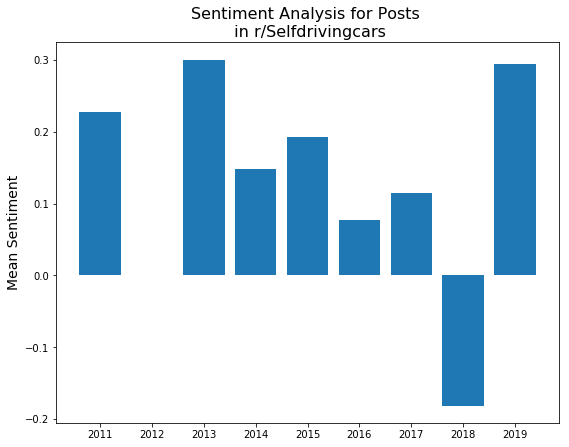

In [9]:
# Plot Sentiment Analysis for r/selfdrivingcars Submissions/posts

plt.figure(figsize = (9, 7))
plt.bar(sdc_sub_sent_yr.index, sdc_sub_sent_yr);

plt.title('Sentiment Analysis for Posts \n in r/Selfdrivingcars', size= 16)
plt.xticks((2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019))
plt.ylabel('Mean Sentiment', size = 14 )
plt.savefig('plots/sent_sdc_subs.png')

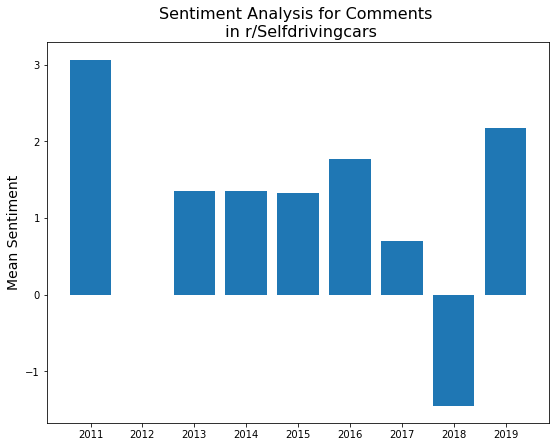

In [10]:
# Plot Sentiment Analysis for r/Selfdrivingcars Comments

plt.figure(figsize = (9, 7))
plt.bar(sdc_com_sent_yr.index, sdc_com_sent_yr);

plt.title('Sentiment Analysis for Comments \n in r/Selfdrivingcars', size= 16)
plt.xticks((2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019))
plt.ylabel('Mean Sentiment', size = 14 )
plt.savefig('plots/sent_sdc_coms.png')

We see generally positive sentiment for all years of the subreddits existence, as is to be expected for this subreddit, with the exception of 2018.  With such a sharp drop in this year, I would assume there is either a data corruption, or that some news event affected reddit users during this particular year. 

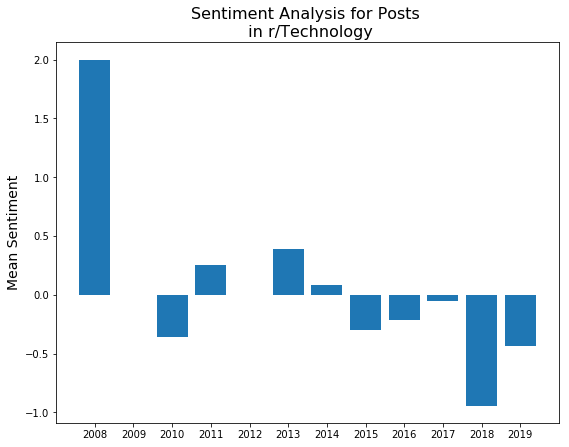

In [11]:
# Plot Sentiment Analysis for r/Technology Posts

plt.figure(figsize = (9, 7))
plt.bar(tech_sub_sent_yr.index, tech_sub_sent_yr);

plt.title('Sentiment Analysis for Posts \n in r/Technology', size= 16)
plt.xticks((2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019))
plt.ylabel('Mean Sentiment', size = 14 )
plt.savefig('plots/sent_tech_subs.png')

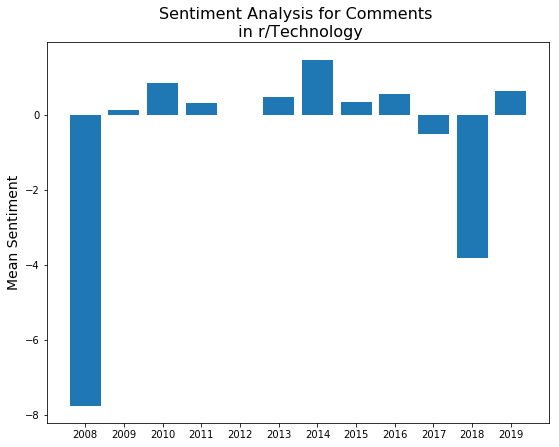

In [14]:
# Plot Sentiment Analysis for r/Technology Comments

plt.figure(figsize = (9, 7))
plt.bar(tech_com_sent_yr.index, tech_com_sent_yr);

plt.title('Sentiment Analysis for Comments \n in r/Technology', size= 16)
plt.xticks((2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019))
plt.ylabel('Mean Sentiment', size = 14 )
plt.savefig('plots/sent_tech_coms.png')

Technology has noticeably lower sentiment throughout all years, with a strange phenomena in 2008 where Submission sentiment was high but comments were extremeley low. This could be a result of an extremely controversial topic in that year, or due to the sentiment analyzer misreading the Submission text data.  Again we see 2018 with a sharp drop similar to r/selfdrivingcars.

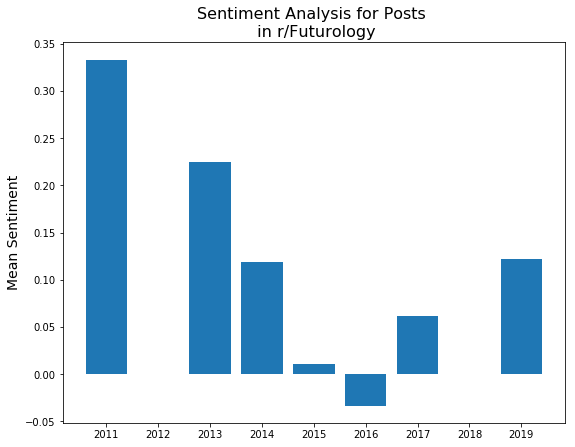

In [12]:
# Plot Sentiment Analysis for r/Futurology Posts

plt.figure(figsize = (9, 7))
plt.bar(fut_sub_sent_yr.index, fut_sub_sent_yr);

plt.title('Sentiment Analysis for Posts \n in r/Futurology', size= 16)
plt.xticks((2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019))
plt.ylabel('Mean Sentiment', size = 14 )
plt.savefig('plots/sent_fut_subs.png')

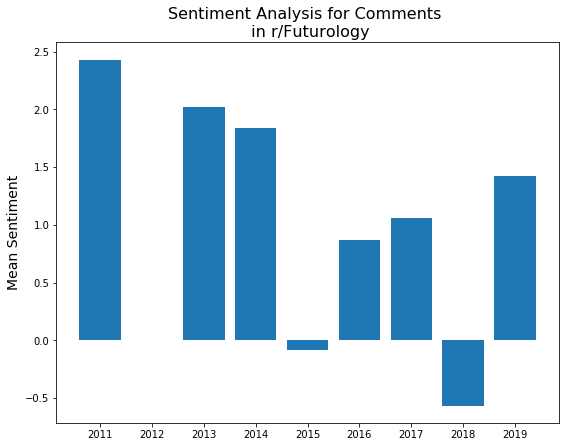

In [13]:
# Plot Sentiment Analysis for r/Futurology Comments

plt.figure(figsize = (9, 7))
plt.bar(fut_com_sent_yr.index, fut_com_sent_yr);

plt.title('Sentiment Analysis for Comments \n in r/Futurology', size= 16)
plt.xticks((2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019))
plt.ylabel('Mean Sentiment', size = 14 )
plt.savefig('plots/sent_fut_coms.png')

Futurology shows much higher sentiment than technology across all years of existence.  It was on a steady decline from 2011 to 2016, but has beeen on an upwards trend for most of the past three years, with the 2018 drop being an anomaly.  

### Summary Plot of Logistic Regression Accuracy Submission vs Comments

In [171]:
#algos = ['LogReg_cv', 'SVC', 'RF']
#accuracies = [0.891, 0.896, 0.899]

In [173]:
algo2 = ['LogReg Posts', 'LogReg Comments']
accs_2 = [0.891, 0.826]

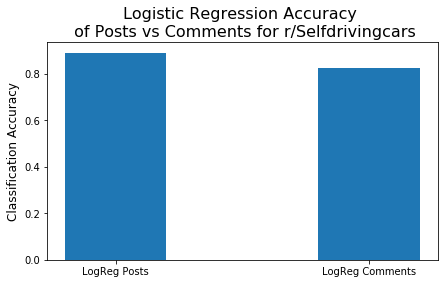

In [175]:
plt.figure(figsize = (7,4))
plt.bar(x=algo2, height=accs_2, width= 0.4);
plt.title('Logistic Regression Accuracy \n of Posts vs Comments for r/Selfdrivingcars', size = 16)
plt.ylabel('Classification Accuracy', size=12)
plt.savefig('plots/posts_v_coms.png')

## Summary and Conclusions

Considering Futurology vs Technology sentiment trends overtime, Futurology would provide a best alternative subreddit for Tesla to target with marketing advertisements.  The control subreddit group, r/selfdrivingcars, would also provide a good customer base to target, as we saw with high sentiment across the entire life of the group, but it only has 55k members.  Futurology has 14.2 million members, providing 18 times more potential customers to target.

Comparing the three models, they all performed roughly the same on Submission Data at 90%. However, we saw that Support Vector Machine with 'linear' kernel provided the least overfit of the three models.  We only tested Logistic Regression and Support Vector Machine on Comments data, both of which scored around 83%, but again the Support Vector Machine model was the only model that best fit the entire data, including the test data.  Logistic Regression was overfit.
